##**Imports**

In [191]:
# For sampling
import random
import numpy as np

# for parsing directory
import glob

# tf
import tensorflow as tf

# import pprint

# Imports for image plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
%matplotlib inline
import sys


# A python code with pprint 
import requests 
from pprint import pprint


import tensorflow
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Flatten, Dense, Concatenate, Dot, Lambda, Input
from tensorflow.keras.layers import Conv2D, Activation,AveragePooling2D, Dropout

from tensorflow.keras.models import Sequential, Model

##**DATA**

###**Get Data**

In [2]:
workspace_dir = '.'
!gdown --id 1xX54Sr1R57yJaxQ3UrVU5Hp86ZUlrg_J --output "{workspace_dir}/Omniglot.tar.gz"

Downloading...
From: https://drive.google.com/uc?id=1xX54Sr1R57yJaxQ3UrVU5Hp86ZUlrg_J
To: /content/Omniglot.tar.gz
26.4MB [00:00, 84.1MB/s]


In [3]:
!tar -zxf "{workspace_dir}/Omniglot.tar.gz" -C "{workspace_dir}/"

###**Make Dataset**



    How to make dataset: K-way, N-shot, train_ratio, total_background_classes,q-shot, total_val_classes
        Support Set must be having K Classes (a class is a character), 
        N examples each.

        Query Set can have N images of each of K classes

        Sampling : 
                Get path of all classes (not images)
                Split into train and Val Set
                Split train set into Support and Query


        Implementation Perspective:
                a : Parse direcotry to get name of all classes for background
                b : Parse direcotry to get name of all classes for val
                c : do shuffling of 'a' output and 'b' output
                d : for each class get path of all images and randomly sample N+q images, store N of these in Support and q in Query
                e : generate labels
                f : zip labels with Query and Support for both background and val
                g : zip Query and Support for both background and val
                h : make dataset out of that zip.
                i : map dataset with parser
                j : map parser with additional addon functionalities
                k : get batch of size=K
                l : shuffle elements in batch (warning don't shuffle before making batch)
                m : Relax!




        Special Note for shuffling instances if separate dataset for Supporting and Query are made rather then Separating Query and Support on training time
                - make separate datasets for Query and Sypport sets
                - Make label array for one task (K classes and N[x]*K total Images)
                - Repeat that label array total_batches times
                - total_images = N[x]*total_classes[y]  
                              x = 0/1, denote shot for support or query
                              y = o/1, denote classes present in background_set(0) or evaluation_set (1)
                - total_batches = total_images/batch_size
                - batch_size = N[x]*K 
                              x =  0/1, denote shot for support or query
                              K = K-way


        SHUFFLE IMAGES WITHIN A TASK TO AVOID MODEL FROM LEARNING SEQUENCE OF CLASSES


###**Helper Code**

In [6]:
def get_labels(K, N, total_batches):
  labels =  np.repeat(np.arange(K),N)
  sequence = []
  for i in range(int(total_batches)):
    sequence.extend(labels)
  return sequence

# def parse_function(filename, label):
#     image_string = tf.io.read_file(filename)

#     #Don't use tf.image.decode_image, or the output shape will be undefined
#     image = tf.image.decode_jpeg(image_string, channels=1)

#     #This will convert to float values in [0, 1]
#     image = tf.image.convert_image_dtype(image, tf.float32)

#     image = tf.image.resize(image, [64, 64])
#     return image, label


def train_preprocess(image, label):
    # image = tf.image.random_flip_left_right(image)

    # image = tf.image.random_brightness(image, max_delta=32.0 / 255.0)
    # image = tf.image.random_saturation(image, lower=0.5, upper=1.5)

    #Make sure the image is still in [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label
    
class _Parser:

  @staticmethod
  def getF(directory, x="both"):
      # x could be "files" or "folders" or "both"

      if directory[-1] != "/":
        directory += "/"

      folders = []
      for f in walk(directory):
        folders.extend(f)
        # ???

      if x == "folders":
        return folders[1]

        
        
          
      if x == "files":
          return folders[2]
      else:
        return folders[1], folders[2]


  @staticmethod
  def parse_img_pair(x1, x2):

    
    image_string1 = tf.io.read_file(x1)
    image_string2 = tf.io.read_file(x2)

    #Don't use tf.image.decode_image, or the output shape will be undefined
    image1 = tf.image.decode_jpeg(image_string1, channels = image_shape(2))
    image2 = tf.image.decode_jpeg(image_string2, channels = image_shape(2))

    #This will convert to float values in [0, 1]
    image1 = tf.image.convert_image_dtype(image1, tf.float32)
    image2 = tf.image.convert_image_dtype(image2, tf.float32)

    image1 = tf.image.resize(image1, [image_shape(0), image_shape(1)])
    image2 = tf.image.resize(image2, [image_shape(0), image_shape(1)])
    return image1, image2
      

In [5]:

# algorithm to shuffle indices so that indices within specific range(window_size) stays there.
# within a loop get random numbers in a range(equal to wnindow size)
# keep making array bigger and bigger as loop continues
def get_shuffled_windows(total_indices, window_size):
  loop_range = total_indices//window_size
  shuffled_indices = []
  for i in range(loop_range):
    shuffled_indices.extend(random.sample(range(window_size*i,i*window_size+window_size), window_size))

  if len(shuffled_indices) != total_indices:
    total_indices_left = (total_indices-len(shuffled_indices))
    shuffled_indices.extend(random.sample(range(len(shuffled_indices), len(shuffled_indices) + window_size), total_indices_left))

  return shuffled_indices






###**Make tf.data for Omniglot directory**

In [160]:
def get_omniglot(directory, background="images_background", evaluation="images_evaluation", seed=-1, N=(1,1), K=5, K_total=(30,20), shuffle_task=1, same_set_indices=0, image_shape=(64,64,1)):

  
    
  def parse_function(filename, label):
      image_string = tf.io.read_file(filename)

      #Don't use tf.image.decode_image, or the output shape will be undefined
      image = tf.image.decode_jpeg(image_string, channels=1)

      #This will convert to float values in [0, 1]
      image = tf.image.convert_image_dtype(image, tf.float32)

      image = tf.image.resize(image, [image_shape[0], image_shape[1]])
      return image, label


  if directory[-1] != "/":
    directory = directory + "/"
  total_sup_images_background = N[0]*K_total[0]
  total_q_images_background = N[1]*K_total[0]

  total_sup_images_evaluation = N[0]*K_total[1]
  total_q_images_evaluation = N[1]*K_total[1]

  support_batch_size = N[0]*K
  query_batch_size = N[1]*K
  
  total_sup_batches_background = total_sup_images_background//support_batch_size
  total_q_batches_background = total_q_images_background//query_batch_size


  total_sup_batches_evaluation = total_sup_images_evaluation//support_batch_size
  total_q_batches_evaluation = total_q_images_evaluation//query_batch_size

  if total_sup_batches_background != total_q_batches_background:
    print("Err")
    print(str(total_q_batches_background) + " " + str(total_sup_batches_background))
    sys.exit(0)


  if total_sup_batches_evaluation != total_q_batches_evaluation:
    print("Err")
    print(str(total_q_batches_evaluation) + " " + str(total_sup_batches_evaluation))
    sys.exit(0)

  # NOTE : shots for Query and Evaluation can be different but K ca not be different.

  background_classes_to_sample = K_total[0]
  eval_classes_to_sample = K_total[1]

  support_shot = N[0]
  query_shot = N[1]


  background_classes = [f for f in glob.glob(directory + background +"/" + "**/character*",recursive=True)]
  evaluation_classes = [f for f in glob.glob(directory + evaluation +"/" + "**/character*",recursive=True)]

  if seed < 0:
    random.shuffle(background_classes)
    random.shuffle(evaluation_classes)
  else:
    random.Random(seed).shuffle(background_classes)
    random.Random(seed).shuffle(evaluation_classes)


  # Randomly chose only required number of classes for both sets
  if background_classes_to_sample > 1:
    background_classes = random.sample(background_classes, background_classes_to_sample)

  if eval_classes_to_sample > 1:
    evaluation_classes = random.sample(evaluation_classes, eval_classes_to_sample)
  
  query_set   = []
  support_set = []

  # class_id is used to verify whether our sampling, randomizing and labeling is done correctly or not
  # outer indices = 0:support_set_background, 1:query_set_background, 2:support_set_evaluation, 3:query_set_evaluation
  class_id       = [[],[],[],[]]
  id = 0
  # for each class get N+q images
  for i in background_classes:

    
    img_list = [f for f in glob.glob(i + "**/*.png", recursive=True)]

    # ++ Change needed
    # its better to just use N+q shuffled indices
    if seed < 0:
      random.shuffle(img_list)
    else:
      random.Random(seed).shuffle(img_list)
    img_list = img_list[0:support_shot+query_shot]

    # NOTE : as support and query sets can have different number of images per 
    # class so their batch_size should be different
    # batch_size for support = N[0]*K
    # batch_size for query = N[1]*K
    # labels range for support = [0-K]
    # repeat value for support = N[0]
    # interleave
    # labels range for query = [0-K]
    # repeat value for support = N[0]
    # interleave
    # WARNING : support_shot and support_set names could cause debugging confusion
    support_set.extend(img_list[0:support_shot])
    query_set.extend(img_list[support_shot:])

    current_class_sup_size = len(img_list[0:support_shot])
    current_class_q_size = len(img_list[support_shot:])

    class_id[0].extend([id]*current_class_sup_size)
    class_id[1].extend([id]*current_class_q_size)
    id += 1

  # if randomization within the task required then shuffling within the boundry 
  # of each task to be done separately


  # background batch for support and query
  support_labels = get_labels(K, N[0], total_sup_batches_background)
  support_labels = np.asarray(support_labels).astype('float32')

  if shuffle_task:
    shuffled_windows = get_shuffled_windows( total_indices=len(support_labels), window_size=support_batch_size )
    support_labels = tf.gather(support_labels, shuffled_windows)
    support_set = tf.gather(support_set, shuffled_windows)
    class_id[0] = tf.gather(class_id[0], shuffled_windows)
 


  support_ds_background = tf.data.Dataset.from_tensor_slices((support_set, support_labels))
  support_ds_background = support_ds_background.map(parse_function, num_parallel_calls=4)
  support_ds_background = support_ds_background.map(train_preprocess, num_parallel_calls=4)
  support_ds_background = support_ds_background.batch(support_batch_size)

  query_labels = get_labels(K, N[1], total_q_batches_background)
  query_labels = np.asarray(query_labels).astype('float32')

  
  if shuffle_task:
    shuffled_windows = get_shuffled_windows( total_indices=len(query_labels), window_size=query_batch_size )
    query_labels = tf.gather(query_labels, shuffled_windows)
    query_set_set = tf.gather(query_set, shuffled_windows)
    class_id[1] = tf.gather(class_id[1], shuffled_windows)

  

  query_ds_background = tf.data.Dataset.from_tensor_slices((query_set,query_labels))
  query_ds_background = query_ds_background.map(parse_function, num_parallel_calls=4)
  query_ds_background = query_ds_background.map(train_preprocess, num_parallel_calls=4)
  query_ds_background = query_ds_background.batch(query_batch_size)
  




  query_set   = []
  support_set = []
  label       = []
  id = 0
    # for each class get N+q images
  for i in evaluation_classes: 
    img_list = [f for f in glob.glob(i + "**/*.png", recursive=True)]

    if seed < 0:
      random.shuffle(img_list)
    else:
      random.Random(seed).shuffle(img_list)
    img_list = img_list[0:support_shot+query_shot]

    support_set.extend(img_list[0:support_shot])
    query_set.extend(img_list[support_shot:])

    current_class_sup_size = len(img_list[0:support_shot])
    current_class_q_size = len(img_list[support_shot:])

    class_id[2].extend([id]*current_class_sup_size)
    class_id[3].extend([id]*current_class_q_size)
    id += 1


  # background batch for support and query
  support_labels = get_labels(K, N[0], total_sup_batches_evaluation)
  support_labels = np.asarray(support_labels).astype('float32')





  if shuffle_task:
    shuffled_windows = get_shuffled_windows( total_indices=len(support_labels), window_size=support_batch_size )
    support_labels = tf.gather(support_labels, shuffled_windows)
    support_set = tf.gather(support_set, shuffled_windows)
    class_id[2] = tf.gather(class_id[2], shuffled_windows)


  support_ds_evaluation = tf.data.Dataset.from_tensor_slices((support_set, support_labels))
  support_ds_evaluation = support_ds_evaluation.map(parse_function, num_parallel_calls=4)
  support_ds_evaluation = support_ds_evaluation.map(train_preprocess, num_parallel_calls=4)
  support_ds_evaluation = support_ds_evaluation.batch(support_batch_size)

  query_labels = get_labels(K, N[1], total_q_batches_evaluation)
  query_labels = np.asarray(query_labels).astype('float32')


  if shuffle_task:
    shuffled_windows = get_shuffled_windows( total_indices=len(query_labels), window_size=query_batch_size )
    query_labels = tf.gather(query_labels, shuffled_windows)
    query_set_set = tf.gather(query_set, shuffled_windows)
    class_id[3] = tf.gather(class_id[3], shuffled_windows)

  query_ds_evaluation = tf.data.Dataset.from_tensor_slices((query_set,query_labels))
  query_ds_evaluation = query_ds_evaluation.map(parse_function, num_parallel_calls=4)
  query_ds_evaluation = query_ds_evaluation.map(train_preprocess, num_parallel_calls=4)
  query_ds_evaluation = query_ds_evaluation.batch(query_batch_size)

  dataset_background = tf.data.Dataset.zip((support_ds_background, query_ds_background)).batch(1)
  dataset_evaluation = tf.data.Dataset.zip((support_ds_evaluation, query_ds_evaluation)).batch(1)
  # dataset = support_ds_background, query_ds_background, support_ds_evaluation, query_ds_evaluation

  print("Data Summary\n")
  print("N=("+str(N[0])+","+str(N[1])+")")
  print("K_total=("+str(K_total[0])+","+str(K_total[1])+")")
  print("K="+str(K))
  print("\n")
  print("Total support images for background (N[0]*K_total[0]): " + str(total_sup_images_background))
  print("Total query images for background (N[1]*K_total[0]): " + str(total_q_images_background))
  print("\n")
  print("Total support images for evaluation (N[0]*K_total[1]): " + str(total_sup_images_evaluation))
  print("Total query images for evaluation (N[1]*K_total[1]): " + str(total_q_images_evaluation))
  print("\n")
  print("Support Batch Size (N[0]*K) : " + str(support_batch_size))
  print("Query Batch Size (N[1]*K): " + str(query_batch_size))
  print("\n")
  print("Total batches for background: " + str(total_sup_batches_background))
  print("Total batches for evaluation: " + str(total_sup_batches_evaluation))
  
  


  # return dataset
  return dataset_background, dataset_evaluation, class_id



In [170]:
image_shape=(64,64,1)
b, e, id_ds = get_omniglot("/content/Omniglot", image_shape=(64,64,1), N=(2,3), K=5, K_total=(30,20))

Data Summary

N=(2,3)
K_total=(30,20)
K=5


Total support images for background (N[0]*K_total[0]): 60
Total query images for background (N[1]*K_total[0]): 90


Total support images for evaluation (N[0]*K_total[1]): 40
Total query images for evaluation (N[1]*K_total[1]): 60


Support Batch Size (N[0]*K) : 10
Query Batch Size (N[1]*K): 15


Total batches for background: 6
Total batches for evaluation: 4


###**Visualize Meta Tasks**

In [162]:
def show_tasks(tf_data_set, class_id, to_show, show_axis=0, columns=5, img_size=(2,3)):
  # for better visualization put column ==N[x]*K (total_images in one task)

  batch_size = numpy.asarray(tf_data_set._batch_size)

  num_col = columns
  num_row = to_show//num_col

  imgs = []
  labels_o = []
  predictions = []
  id= []
  ii = 0
  imgs_obtained = 0
  break_flag = 0
  task_list = []
  task_no = 1
  for supp, qu in tf_data_set:
    for task in supp[0]:
      
      
      labels = supp[1][0]
      lable_index = 0
      for i,img in enumerate(task):
        imgs.append(numpy.asarray(img[:,:,0]))

        labels_o.extend([int(labels[lable_index])])
        id.extend([class_id[0][ii]])
        lable_index += 1
        ii += 1
        imgs_obtained += 1
        task_list.extend([task_no])

        if imgs_obtained == to_show:
          break_flag = 1
          break

      task_no += 1
      if break_flag:
        break

    if break_flag:
      break

  y_val = img_size[1]
  x_val = img_size[0]


  # plot images
  fig, axes = plt.subplots(num_row, num_col, figsize=(y_val*num_col,x_val*num_row))

  # for j in range(2):
  for i in range(to_show):
      ax = axes[i//num_col, i%num_col]

      if show_axis == 0:
                ax.axes.xaxis.set_visible(False)
                ax.axes.yaxis.set_visible(False)
        
      # if image is (28,28) use below and comment above code
      ax.imshow(imgs[i])
      ax.set_title('Task: {} | y^: {} | id: {}'.format(task_list[i],labels_o[i], id[i]))

  plt.tight_layout()
  plt.show()

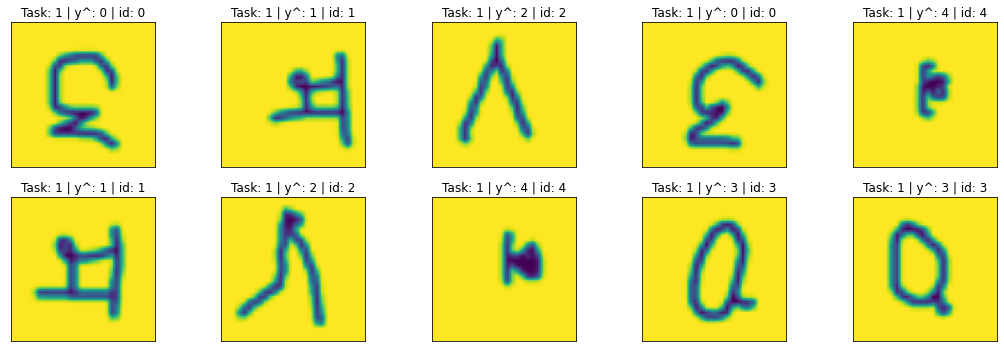

In [164]:
import numpy
show_tasks(b, id, 10, show_axis=0,img_size=(2.5,3))

###**Model**

**MAML Pseudo-Code**

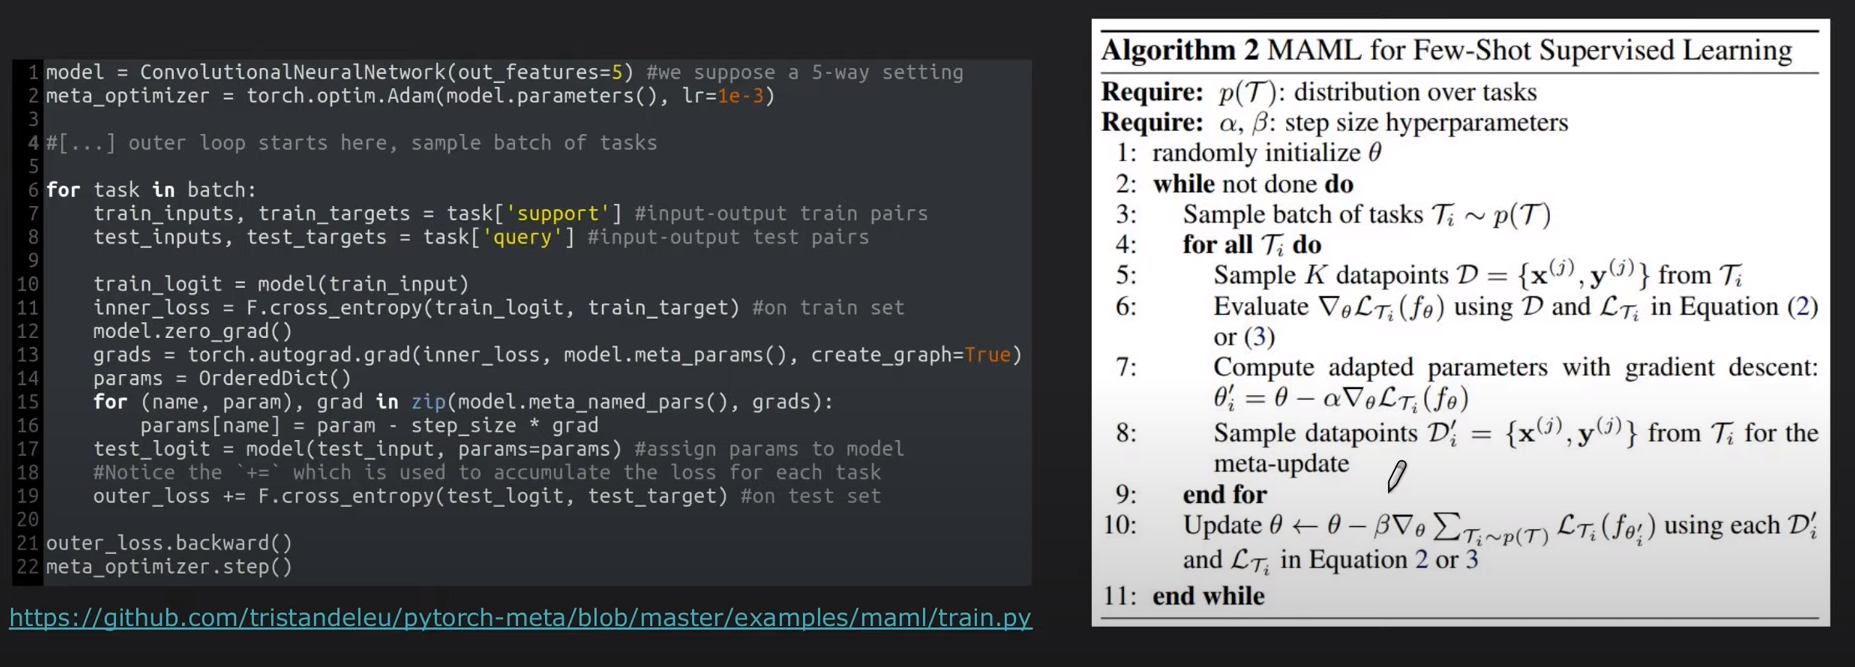

In [197]:
class _Model:
  
  def __init__(self, input_shape, classes_per_task):
    self.input_shape = input_shape
    self.input_height = input_shape[0]
    self.input_width = input_shape[1]
    self.input_channel = input_shape[2]
    self.classes_per_task = classes_per_task
  from keras import backend as K


  def _classifier(self):
    input = Input((self.input_height, self.input_width, self.input_channel))
    x = tf.keras.layers.BatchNormalization()(input)

    x = Conv2D(4, (5,5), activation = 'sigmoid')(x)
    x = AveragePooling2D(pool_size = (2,2))(x)

    x = Conv2D(16, (5,5), activation = 'sigmoid')(x)
    x = AveragePooling2D(pool_size = (2,2))(x)

    x = Conv2D(16, (5,5), activation = 'sigmoid')(x)
    x = AveragePooling2D(pool_size = (2,2))(x)

    x = Flatten()(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = Dense(self.classes_per_task, activation = "softmax")(x)
    _classifier = Model(input, x)


    # input1 = Input((self.input_height,self.input_width,self.input_channel))
    # # input2 = Input((self.input_height,self.input_width,self.input_channel))

    # dense1 = dense(input1)
    # # dense2 = dense(input2)

    # merge_layer = Lambda(_Geometry.euclidean_distance)([dense1,dense2])
    # dense_layer = Dense(1, activation="sigmoid")(merge_layer)
    tf.keras.layers.BatchNormalization()
    # return Model(inputs=[input1, input2], outputs=dense_layer)

    return _classifier

###Test

In [171]:
batch_size = numpy.asarray(b._batch_size)

imgs_to_get = 50
class_id = id_ds
imgs = []
labels_o = []
predictions = []
id= []
ii = 0
imgs_obtained = 0
break_flag = 0
task_list = []
task_no = 1
for supp, qu in b:
  for task in supp[0]:
    
    
    labels = supp[1][0]
    lable_index = 0
    for i,img in enumerate(task):
      imgs.append(numpy.asarray(img[:,:,0]))

      labels_o.extend([int(labels[lable_index])])
      id.extend([class_id[0][ii]])
      lable_index += 1
      ii += 1
      imgs_obtained += 1
      task_list.extend([task_no])

      if imgs_obtained == imgs_to_get:
        break_flag = 1
        break

    task_no += 1
    if break_flag:
      break

  if break_flag:
    break

In [176]:
def get_total_classes(labels, size_of_labels_array): 
  
    res = 1
  
    # Pick all elements one by one 
    for i in range(1, size_of_labels_array): 
        j = 0
        for j in range(i): 
            if (labels[i] == labels[j]): 
                break
  
        # If not printed earlier, then print it 
        if (i == j + 1): 
            res += 1
      
    return res 

In [174]:
print(img.shape)

(64, 64, 1)


In [175]:
# use ids of background support batch for labels of simple non maml model
labels_for_simple_model = id

# labels_for_maml_support within dataset

data_for_simple_model = imgs

In [177]:
output_nodes = get_total_classes(id,len(id))
output_nodes

29

In [196]:
params2 = {
    
    "instances_per_class" : (-1,-1),
    "image_shape"         : (64,64,1),
    "batch_size"          : 16,
    "grey2rgb"            : 0,
    "aug"                 : 0, 
    "parallel_calls"      : 4, 
    "clip_value"          : (0.0,1.0),
    "input_shape"         : (64,64,1),
    "loss"                : tf.keras.losses.CategoricalCrossentropy, 
    "optimizer"           : RMSprop(), 
    "metrics"             : ["accuracy"],
    "epochs"              : 10

}

In [198]:
m = _Model(input_shape=image_shape, classes_per_task=output_nodes)

In [199]:
model1 = m._classifier()

In [200]:
lr_schedule = tensorflow.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9
    )
# optimizer = tensorflow.keras.optimizers.SGD(learning_rate=lr_schedule)
optimizer = tensorflow.keras.optimizers.RMSprop(learning_rate=lr_schedule)

In [202]:
model1.compile(loss = params2["loss"], optimizer=params2["optimizer"], metrics=params2["metrics"])

In [223]:
model1.fit(ds, epochs=params2["epochs"])

Epoch 1/10


TypeError: ignored

In [218]:
# print(numpy.asarray(imgs).shape)
# plt.imshow(img[0])
xx = numpy.asarray(imgs)
yy = numpy.asarray(id)
yy = yy.astype('float32')

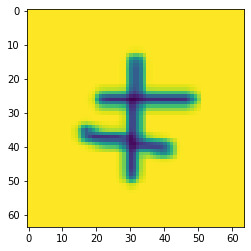

In [225]:
# print(numpy.asarray(imgs).shape)
# plt.imshow(xx[1])

In [221]:
ds = tf.data.Dataset.from_tensor_slices((xx,yy)).batch(16)

In [217]:
xx.dtype

dtype('float32')

###**Other Model**

In [ ]:
def train_maml(model, epochs, dataset, lr_inner=0.01, batch_size=1, log_steps=1000):
    '''Train using the MAML setup.
    
    The comments in this function that start with:
        
        Step X:
        
    Refer to a step described in the Algorithm 1 of the paper.
    
    Args:
        model: A model.
        epochs: Number of epochs used for training.
        dataset: A dataset used for training.
        lr_inner: Inner learning rate (alpha in Algorithm 1). Default value is 0.01.
        batch_size: Batch size. Default value is 1. The paper does not specify
            which value they use.
        log_steps: At every `log_steps` a log message is printed.
    
    Returns:
        A strong, fully-developed and trained maml.
    '''
    optimizer = keras.optimizers.Adam()
    
    # Step 2: instead of checking for convergence, we train for a number
    # of epochs
    for _ in range(epochs):
        total_loss = 0
        losses = []
        start = time.time()
        # Step 3 and 4
        for i, t in enumerate(random.sample(dataset, len(dataset))):
            x, y = np_to_tensor(t.batch())
            model.forward(x)  # run forward pass to initialize weights
            with tf.GradientTape() as test_tape:
                # test_tape.watch(model.trainable_variables)
                # Step 5
                with tf.GradientTape() as train_tape:
                    train_loss, _ = compute_loss(model, x, y)
                # Step 6
                gradients = train_tape.gradient(train_loss, model.trainable_variables)
                k = 0
                model_copy = copy_model(model, x)
                for j in range(len(model_copy.layers)):
                    model_copy.layers[j].kernel = tf.subtract(model.layers[j].kernel,
                                tf.multiply(lr_inner, gradients[k]))
                    model_copy.layers[j].bias = tf.subtract(model.layers[j].bias,
                                tf.multiply(lr_inner, gradients[k+1]))
                    k += 2
                # Step 8
                test_loss, logits = compute_loss(model_copy, x, y)
            # Step 8
            gradients = test_tape.gradient(test_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
            # Logs
            total_loss += test_loss
            loss = total_loss / (i+1.0)
            losses.append(loss)
            
            if i % log_steps == 0 and i > 0:
                print('Step {}: loss = {}, Time to run {} steps = {}'.format(i, loss, log_steps, time.time() - start))
                start = time.time()
        plt.plot(losses)
        plt.show()

In [ ]:
def copy_model(model, x):
    '''Copy model weights to a new model.
    
    Args:
        model: model to be copied.
        x: An input example. This is used to run
            a forward pass in order to add the weights of the graph
            as variables.
    Returns:
        A copy of the model.
    '''
    copied_model = SineModel()
    
    # If we don't run this step the weights are not "initialized"
    # and the gradients will not be computed.
    copied_model.forward(tf.convert_to_tensor(x))
    
    copied_model.set_weights(model.get_weights())
    return copied_model

NameError: ignored